## Introduction
* The task at hand is to quantify the impact of the Kenyan government policy interventions to  slow the spread of the current pandemic: COVID19.
* The **'behind the scenes'** of the model used is in this [repository](https://github.com/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb). The repo takes care of all the steps from data scraping to model formulation. Credits to [Jonas Dehning](https://science.sciencemag.org/content/369/6500/eabb9789), [Michael Wibral](https://science.sciencemag.org/content/369/6500/eabb9789) et.al.
* Find the reserach publication [here](https://science.sciencemag.org/content/369/6500/eabb9789).
* An overview of the model:  It performs bayesian inferencing for the central  epidemiological parameters of an SIR model using MCMC sampling  to compute the posterior distribution of the parameters and to sample from it for forecasting.The SIR  model is generalized with stationary spreading rate for change point(interventions) detection. 
* The interventions explored are:
    * 6th April 2020 – Ban on movement in Nairobi, Kilifi, Kwale, and Mombasa counties and imposing of the dusk to dawn curfew
    * 7th May 2020 - Lockdown in Eastleigh (Nairobi) and Old Town (Mombasa city)
    * 6th July 2020  - Movement restrictions  lifted in Nairobi, Mombasa, and Mandera counties.

## Table of Contents
* [Prerequisites](#The-Model-Module)
* [Libraries](#Libraries)
* [Dataset and Preprocessing](#Dataset-+-Preprocessing)
* [Visualisations](#Visualisations)
* [Model Specifics (Train set)](#Model-Specifics)
    1. [Date Range and Getting Specific Data](#Date-Range-and-Specific-Data)
    2. [Train and Validation sets](#Train-and-Validation-sets)
    3. [Change points priors](#Change-points-priors)
    4. [Model Creation and Parameters Tuning](#Model-Creation-and-Hyperparameters-tuning.)
    5. [Model Fitting](#Model-Fitting)
    6. [Distributions](#Distributions)
    7. [Predictions Time Series plot](#Predictions-time-series-plot)
    8. [Model Evaluation](#Model-Evaluation)
* [Model Rerun (Final Predictions)](#Reruning-the-model-with-the-whole-dataset-and-predict-until-10th-August.)

### The Model Module

In [2]:
# installs the covid19_inference library
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git@v0.1.8

  Cloning https://github.com/Priesemann-Group/covid19_inference.git (to revision v0.1.8) to /tmp/pip-req-build-5yjnjdwc
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-5yjnjdwc
  Running command git checkout -b v0.1.8 --track origin/v0.1.8
  Switched to a new branch 'v0.1.8'
  Branch 'v0.1.8' set up to track remote branch 'v0.1.8' from 'origin'.
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=102471 sha256=b5925e4e59a3e8bf6bc53697907288b41069d3e9f4c022d8add285e79f39baa4
  Stored in directory: /tmp/pip-ephem-wheel-cache-nvot4198/wheels/42/e7/e7/ee2035dd9edc0646359231afc5b2af9bf89c40c8256e0d6dba
Successfully built covid19-inference


### Libraries

In [3]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import covid19_inference as cov19
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset + Preprocessing

In [4]:
# Using the covid19_inference to download data from John Hopkins University (JHU) 
jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


In [28]:
# getting the Kenyan confirmed, recovered, deaths numbers from JHU data
dfKe = jhu.get_total_confirmed_deaths_recovered(country="Kenya")

# get the rows where the number of cases are more than a 100
dfKe100 = dfKe.loc[dfKe['confirmed'] >= 100]
dfKe100.tail(10)

,confirmed,deaths,recovered
date,,,
2020-07-29,19125,311,8021
2020-07-30,19913,325,8121
2020-07-31,20636,341,8165
2020-08-01,21363,364,8419
2020-08-02,22053,369,8477
2020-08-03,22597,382,8740
2020-08-04,23202,388,9327
2020-08-05,23873,391,9930
2020-08-06,24411,399,10444


In [6]:
# Check if the date column has null values
dfKe100.reset_index()['date'].isna().sum()

0

### Visualisations

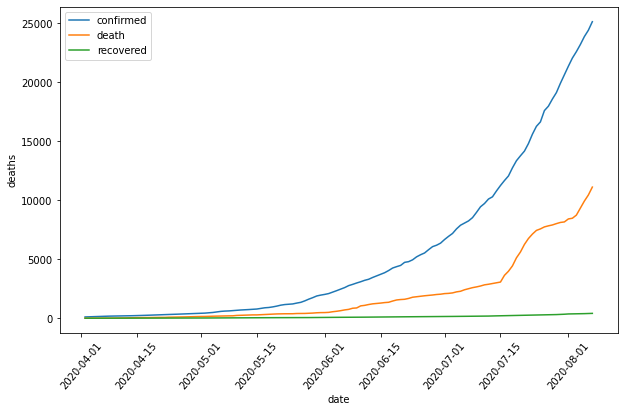

In [24]:
# confirmed - recovered - death trends
plt.figure(figsize = (10,6))
sns.lineplot(x=dfKe100.index, y=dfKe100.confirmed)
sns.lineplot(x=dfKe100.index, y=dfKe100.recovered)
sns.lineplot(x=dfKe100.index, y=dfKe100.deaths)
plt.xticks(rotation = 50)

plt.legend(['confirmed', 'death', 'recovered'])

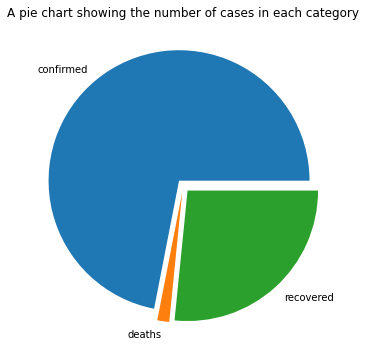

In [34]:
a = dfKe100.copy()
a.loc['total'] = a.sum()  #add a totals row

fig = plt.figure(figsize =(9, 6)) 
explode = (0.05, 0.05, 0.05) 
plt.pie(a.loc['total'], labels = a.columns, explode = explode)
plt.title('A pie chart showing the number of cases in each category')
plt.show()

Total confirmed cases is bound to have the largest percentage given the natural progression of the situation. From infection to recovery or death. 
The number of deaths is approximately at least a tenth of the number of recovered cases, this indicates a low mortality rate of the disease.

### Model Specifics

#### Date Range and Specific Data

In [7]:
bd = datetime.datetime(2020, 4, 2)  # For the date filter (The first day with more than a 100 confirmed cases)
ed = datetime.datetime.now()

# geting the number of new cases for each day
new_cases_obs = jhu.get_new(
    value="confirmed", country="Kenya", data_begin=bd, data_end=ed
)

#### Train and Validation sets

In [8]:
X = new_cases_obs
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

In [9]:
print(X_test.shape)  #forecasting days

(26,)


#### Change points priors

In [10]:
# Creating the priors for change points and other configuration

diff_data_sim = 16  # should be significantly larger than the expected delay, in
num_days_forecast = 26

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 6)
prior_date_strong_dist_begin = datetime.datetime(2020, 5, 7)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 6)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]

#### Model Creation and Hyperparameters tuning.

In [11]:
"""
    Next, we create the model! There are default values for most of the function arguments,
    but we will try to explicitly set all kwargs for the sake of this example.
"""
params_model = dict(
    new_cases_obs=X_train[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=50e6,
)

# Median of the prior for the delay in case reporting, we assume 3 days
pr_delay = 3

"""
    The model is specified in a context. Each function in this context
    has access to the model parameters set.
"""
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

#### Model Fitting

In [12]:
"""## MCMC sampling

    After the model is built, it is sampled using an MCMC sampler.
    The number of parallel runs can be set with the argument `cores=`.
    In particular, due to a bug in Theano, Windows users should set `cores=1`.
    The sampling can take a long time.
"""

trace = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 661.59:  20%|██        | 40093/200000 [06:30<25:57, 102.68it/s]
Convergence achieve

#### Distributions

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


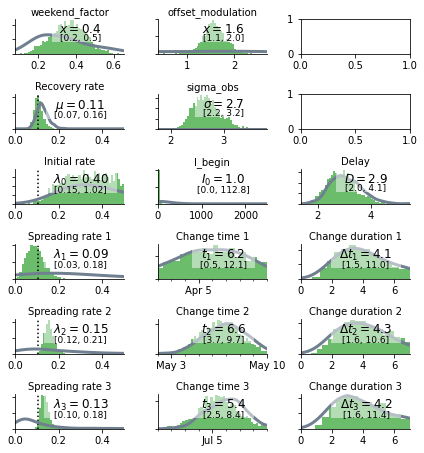

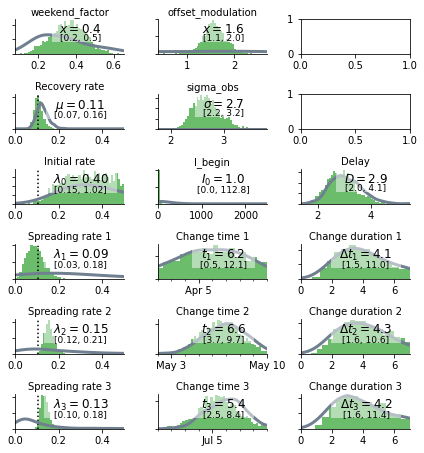

In [13]:
"""## Plotting
    Plotting tools are rudimentary right now. But one can always write custom plotting function
    by accessing the samples stored in the trace.

    ### Distributions
"""
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig

The plots above show the change in the spreading rate at different change points (intervention points) and initially (prior).


#### Predictions time series plot

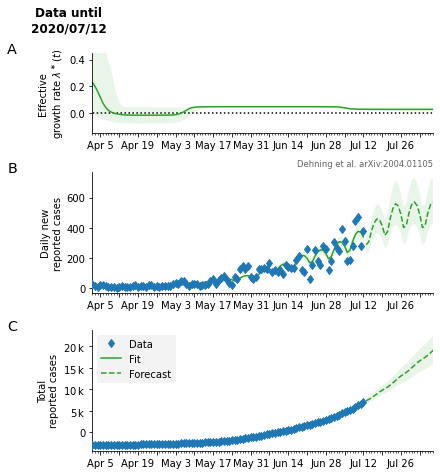

In [15]:
"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

#### Model Evaluation

In [16]:
# Getting the forecast values from the model
fcast_x, fcast_y = cov19.plot._get_array_from_trace_via_date(this_model, trace, 'new_cases', this_model.fcast_begin, this_model.fcast_end )

In [21]:
# # Evaluating the models performance i.e how accurate is the model
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# mean_squared_error(X_test.head(26), fcast_x[0])**0.5

In [20]:
# # Create a multiplot
# fig1, axes1 = plt.subplots(2,1, figsize=(12,6))

# # Visual representation of the models performance
# cov19.plot._timeseries(x=X_test.head(26).index, y=X_test.head(26), ax=axes1[0], what='model')
# cov19.plot._timeseries(x=fcast_y, y=fcast_x[0],ax=axes1[1], what='model')

# # Label the plots

# axes1[0].set_title("accurate values")

# axes1[1].set_title("forecasted values")

# # Show the figure
# fig1.show()
# fig1

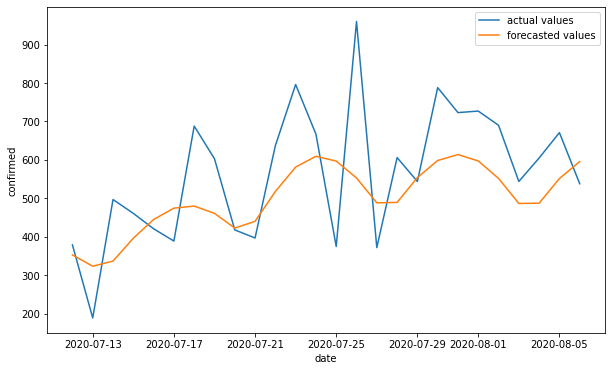

In [ ]:
# On the same plot
plt.figure(figsize = (10,6))
sns.lineplot(x=X_test.index, y=X_test, legend = 'brief')
sns.lineplot(x=fcast_y, y=fcast_x[0], legend = 'full')
plt.legend(['actual values', 'forecasted values'])

The trend predictions are not good, but overally the model highlights rises and falls at the right ranges. (The peaks and falls predictions do not match the actual figures though.) But all in all, the scale is not bad. 
This is the best prediction the group could come up with at the moment after retuning some parameters and rerunning the model over and over again. 

### Reruning the model with the whole dataset and predict until 10th August.

In [38]:
# Creating the priors for change points and other configuration

diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 7 # prediction days

# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 4, 6)
prior_date_strong_dist_begin = datetime.datetime(2020, 5, 7)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 6)

change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]


In [39]:
"""
    Next, we create the model! There are default values for most of the function arguments,
    but we will try to explicitly set all kwargs for the sake of this example.
"""
params_model = dict(
    new_cases_obs=X[:], # Data Change
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=50e6,
)

# Median of the prior for the delay in case reporting, we assume 3 days
pr_delay = 3

"""
    The model is specified in a context. Each function in this context
    has access to the model parameters set.
"""
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)


INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

In [40]:
"""## MCMC sampling

    After the model is built, it is sampled using an MCMC sampler.
    The number of parallel runs can be set with the argument `cores=`.
    In particular, due to a bug in Theano, Windows users should set `cores=1`.
    The sampling can take a long time.
"""

trace = pm.sample(model=this_model, tune=500, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 918:  20%|██        | 40195/200000 [06:43<26:42, 99.70it/s]
Convergence achieved at 40200
INFO     [pymc3.variational.inference] Convergence achieved at 40200
Interrupted at 40,199 [20%]: Average Loss = 951.77
INFO     [pymc3.variational.inference] Interrupted at 40,199 [20%]: Average Loss = 951.77
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, 

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_log_', 'transient_len_2_log_', 'transient_len_3_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


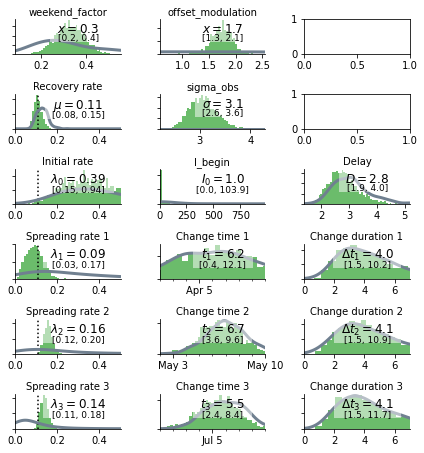

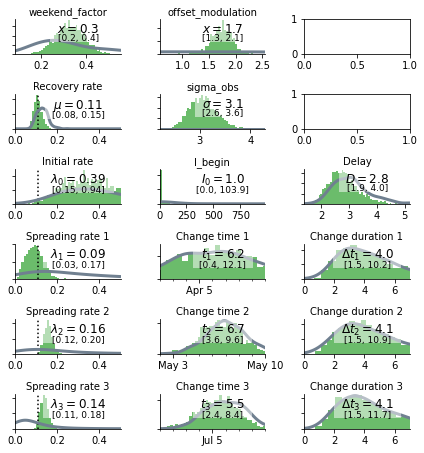

In [41]:
"""## Plotting
    Plotting tools are rudimentary right now. But one can always write custom plotting function
    by accessing the samples stored in the trace.

    ### Distributions
"""
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

# Plot them
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

fig.tight_layout()
fig

The plots above show the change in the spreading rate at different change points (intervention points)/times and initially (prior).
Specifics can be found in the report.

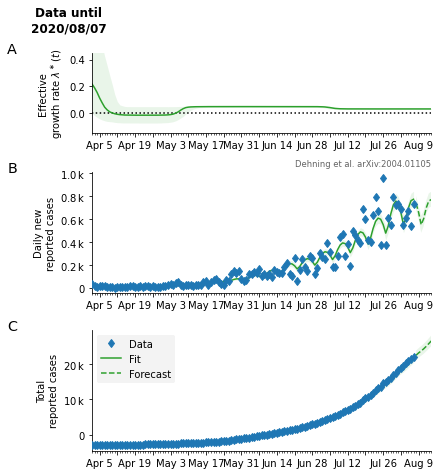

In [42]:
"""### Timeseries
    timeseries overview, for now needs an offset variable to get cumulative cases
"""
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=-3000)

In [43]:
# ## the week of August 10th predictions
fcast_x, fcast_y = cov19.plot._get_array_from_trace_via_date(this_model, trace, 'new_cases', this_model.fcast_begin, this_model.fcast_end )
c = pd.DataFrame([fcast_y, fcast_x[0]])
c = c.transpose()
c.columns = ['date', 'predicted new_cases']
c['predicted new_cases'] = c['predicted new_cases'].astype(int)
c

,date,predicted new_cases
0,2020-08-08,740
1,2020-08-09,652
2,2020-08-10,532
3,2020-08-11,583
4,2020-08-12,692
5,2020-08-13,761
6,2020-08-14,777


In [45]:
pm.save_trace(trace)

'.pymc_2.trace'

[Back to top](#Introduction)